线上auc=0.615555

目录：
    特征工程
    样本空间泛化
    算法性能泛化
    迁移模型
    模型融合
    
这里，因为模型实在是没看懂，所以只整理特征工程部分：
    特征可视化；特征分组；利用特征重要性进行选择

In [4]:
# 数据读取

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from xgboost.sklearn import XGBClassifier as XGBC
from sklearn.metrics import roc_auc_score as AUC

data_a = pd.read_csv('../data/A_train.csv')
data_b = pd.read_csv('../data/B_train.csv')
test = pd.read_csv('../data/B_test.csv')

### 特征工程


一、高阶统计特征
    1）0、1、NULL和连续型数值计数
    2）特征求和、方差
    3）交叉特征构建：
    从保留的特征信息中做特征分组 以productinfo、userinfo、webinfo 建立三个特征视图，做交叉，得到600维特征
    
二、特征选择
    利用树模型xgboost模型预训练，提取前400个特征
三、特殊值处理
    1）NULL值：填充-1
    2）连续值：取对数
    
学习：特征可视化；特征分组；利用特征重要性进行选择

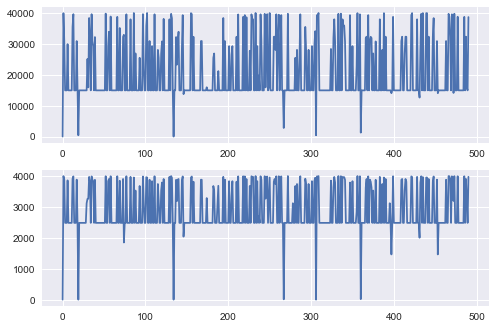

In [11]:
# train_data visualization
fea = np.sum(data_a.isnull(),axis=0) # 查看每一列的空值个数：
feb = np.sum(data_b.isnull(),axis=0)
plt.subplot(211).plot(fea.values) # 分成2x1，占用第一个，即第一行
plt.subplot(212).plot(feb.values) # 分成2x1，占用第二个，即第二行
plt.show()

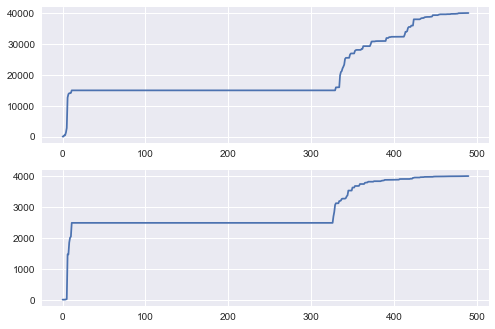

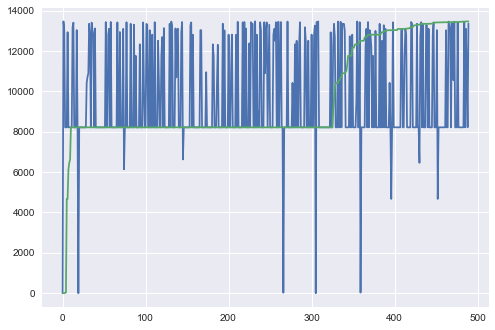

In [12]:
# sort_data visualization
plt.subplot(211).plot(np.sort(fea))
plt.subplot(212).plot(np.sort(feb))
plt.show()
# test_data visualization
fet = np.sum(test.isnull(),axis=0)
plt.plot(fet.values)
plt.plot(np.sort(fet))
plt.show()

In [17]:
# 选择特征，以330号特征的空值数量进行选择

a = fea[fea==fea[330]]
b = feb[feb==feb[330]]
t = fet[fet==fet[330]]

# save common features in a,b,t
c = a.index.difference(a.index.difference(b.index)) # difference（）可以获得差集，但是这个差集是“出现在第一个集合但不出现在第二个集合”的元素
c = c.difference(c.difference(t.index))
c = pd.DataFrame(c)
c = c.append(['ProductInfo_89'])
c = c[c[0]!='no']
c.to_csv('../config/index.csv',index=False)

In [22]:
# train these features select those importance > 0
clf1 = XGBC(max_depth=8,seed=999,n_estimators=100)
train = data_b.sample(3000,random_state=999)
v = data_b[~data_b['no'].isin(train['no'])]
clf1.fit(train[train.columns.difference(['flag','no'])],train['flag'])
p = clf1.predict_proba(v[v.columns.difference(['flag','no'])])[:,1]
print(AUC(v['flag'],p))
# print clf1.feature_importances_
a  = pd.Series(clf1.feature_importances_)
ind = v.columns.difference(['flag','no'])
a.index=ind
select_a = a[a>0]

0.5776150152488482


In [26]:
# log smoothing平滑
data_a['ProductInfo_89'] = (np.log(data_a['ProductInfo_89'].fillna(-1)+1.1)).astype(np.int)
data_b['ProductInfo_89'] = (np.log(data_b['ProductInfo_89'].fillna(-1)+1.1)).astype(np.int)
test['ProductInfo_89'] = (np.log(test['ProductInfo_89'].fillna(-1)+1.1)).astype(np.int)

In [29]:
# features grouped by name

cu=[];cp=[];cw=[]
for i in cross.index:
    if(i[0]=='P'):
        cp.append(i)
    if(i[0]=='U'):
        cu.append(i)
    if(i[0]=='W'):
        cw.append(i)
print(len(cu),len(cp),len(cw)) 

93 45 1


In [31]:
# cross-features using web_info and product_info
for i in cw:
    for j in cp:
        data_a[i+j] = data_a[i]*data_a[j]
        data_b[i+j] = data_b[i]*data_b[j]
        test[i+j] = test[i]*test[j]
print(data_a.shape,data_b.shape,test.shape)

(40000, 536) (4000, 536) (13463, 535)


In [32]:
# save new data_set
data_a.to_csv(r'../inter/A_train.csv',index=False)
data_b.to_csv(r'../inter/B_train_new.csv',index=False)
test.to_csv(r'../inter/B_test_new.csv',index=False)

## 样本空间泛化

1.训练数据B珍贵，故偏好over-sampling，采样方法：smote over-sampling  
2.考虑A，B数据集差异性，不可过分依靠A，所以对A_train进行有效提取样本  
3.考虑辅助样本B_test的信息没有利用到，犹豫B_train规模太小，所以考虑将B_test信息融入到训练样本中，泛化样本空间


## 后续模型看不懂了，就不整理了

参考：https://www.kesci.com/apps/home/competition/forum/595a0df08bbf940ae1b65224